<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: San Antonio and Bexar County
---

## Overview

Addresses the request in GitHub [Issue #48](https://github.com/texas-justice-initiative/website/issues/48) on the TJI website repo:

## Questions and findings

#### 1. Demographics of officers involved from Bexar County Sheriff's Office and San Antonio Police Department compared to the overall demographics of those departments per TCOLE 

See plots for [race](https://github.com/texas-justice-initiative/analysis/blob/master/plots/san_antonio_officer_race.png), [gender](https://github.com/texas-justice-initiative/analysis/blob/master/plots/san_antonio_officer_gender.png), and [age](https://github.com/texas-justice-initiative/analysis/blob/master/plots/san_antonio_officer_age.png), but in brief:
* Significantly more men were involved in shootings
* Significantly more hispanic officers were involved in shootings
* Significantly younger officers were involved in shootings

#### 2. How many of Texas' officer-involved shootings are in Bexar County? 

* 467 total OIS incidents in Texas (killing 486 civilians)
* 36 incidents involved at least one BCSO/SAPD officer (7.7%)
* 740 total TX officers were recorde in these incidents
* 43 total officers from BCSO/SAPD were recorded (5.8%)
* 45 incidents occurred somewhere in Bexar county (9.6%)
* Bexar county has 7% of the Texas population

#### 3. How many of Texas' custodial deaths are in Bexar County? jails, prisons, police?

* Total custodial deaths in Bexar county since 2005: 274 (3.1% of Texas's total)
* 177 (64.6%) of Bexar's custodial deaths were in police custody (pre-booking)
* 87 (31.8%) of Bexar's custodial deaths were in jail
* 9 (3.3%) of Bexar's custodial deaths were in prison
* 1 (0.4%) of Bexar's custodial deaths were in private facilities

#### 4. Compare racial demographics of custodial deaths to racial demographics of Bexar County? 

See [this plot](https://github.com/texas-justice-initiative/analysis/blob/master/plots/san_antonio_race_cdr_vs_population.png), but in brief:
* Significantly more hispanics and blacks die in custody than the population at large

## Summary of findings


## Datasets used
* `tji/deaths-in-custody/cleaned_custodial_death_reports`
* `tji/officer-involved-shooting/shot_civilians`
* `tji/auxiliary-datasets/list_of_texas_officers`
* `tji/auxiliary-datasets/census_data_by_county`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)
---

In [1]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random
import simplejson as json

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Set up a longer default color palette of very different
# colors for plotting categorical data.
set1 = sns.color_palette('Set1', 9, desat=.5)
super_palette = sns.color_palette('deep', 6) + [set1[7], set1[6], set1[4], set1[8]]
sns.set_palette(super_palette)

# It's useful to have some named colors handy
(SNS_BLUE, SNS_GREEN, SNS_RED,
 SNS_PURPLE, SNS_YELLOW, SNS_CYAN,
 SNS_PINK, SNS_BROWN, SNS_ORANGE,
 SNS_GRAY) = super_palette

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2018-07-17 13:33:57 CDT

numpy 1.14.5
pandas 0.23.3
matplotlib 2.2.2
seaborn 0.7.1
datadotworld 1.6.0
watermark 1.6.1


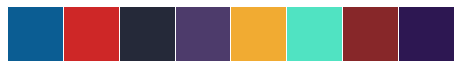

In [2]:
from lib.style import *
from lib.utils import *
sns.palplot(sns.color_palette())

from scipy import stats

## [ Load data ]

In [3]:
cdr = dw.load_dataset('tji/deaths-in-custody', force_update=True).dataframes['cleaned_custodial_death_reports']
print("Loaded %d CDR records" % len(cdr))

shot_civ_full = dw.load_dataset('tji/officer-involved-shootings', force_update=True).dataframes['shot_civilians']
print("Loaded %d civilians-shot records" % len(shot_civ_full))
shot_civ = shot_civ_full.drop_duplicates(subset=['incident_address', 'date_incident'])
print('-- Dropped %d rows beyond the first for an incident' % (len(shot_civ_full) - len(shot_civ)))

officers = dw.load_dataset('tji/auxiliary-datasets', force_update=True).dataframes['list_of_texas_officers']
print("Loaded %d police agency officer population records" % len(officers))

census = dw.load_dataset('tji/auxiliary-datasets', force_update=True).dataframes['census_data_by_county']
print("Loaded %d census county records" % len(census))

Loaded 8872 CDR records
Loaded 486 civilians-shot records
-- Dropped 19 rows beyond the first for an incident
Loaded 77661 police agency officer population records
Loaded 63 census county records


## [1] demographics of officers involved from Bexar County Sheriff's Office and San Antonio Police Department compared to the overall demographics of those departments per TCOLE

In [4]:
plotsaver = PlotSaver('../plots/', 'san_antonio_', numbering=False)

Removing 4 past plots


In [5]:
agencies = ['SAN ANTONIO POLICE DEPT', 'BEXAR CO SHERIFFS OFFICE']
bexar_officers = officers[officers.current_agency.isin(agencies)]
print(bexar_officers['current_agency'].value_counts())

SAN ANTONIO POLICE DEPT     2217
BEXAR CO SHERIFFS OFFICE    1119
Name: current_agency, dtype: int64


In [6]:
bexar_officers['highest_cert'] = bexar_officers['highest_cert'].apply(lambda x: x.split()[0])
bexar_officers.sample(5)

/Users/everettwetchler/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name_full,name_first,name_middle,name_last,name_suffix,gender,race,age_range,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time
3261,SHERMAN E HARRISON,SHERMAN,E,HARRISON,NaN,M,BLACK,51+,BEXAR CO SHERIFFS OFFICE,BEXAR,MASTER,4,24.01
5354,JOHN E FLISS,JOHN,E,FLISS,NaN,M,WHITE,31-40,SAN ANTONIO POLICE DEPT,BEXAR,BASIC,1,4.42
5215,JASON M ENGQUIST,JASON,M,ENGQUIST,NaN,M,WHITE,41-50,SAN ANTONIO POLICE DEPT,BEXAR,MASTER,4,21.67
5656,MARIO D BAKER,MARIO,D,BAKER,NaN,M,BLACK,41-50,SAN ANTONIO POLICE DEPT,BEXAR,MASTER,4,18.67
5132,JACOB E GARCIA,JACOB,E,GARCIA,NaN,M,HISPANIC,31-40,SAN ANTONIO POLICE DEPT,BEXAR,ADVANCED,3,8.25


In [7]:
person_cols = [
 'officer_age',
 'officer_race',
 'officer_gender',
 'agency_name',
 'agency_report_date',
 'agency_city',
 'agency_county',
 'agency_zip',
]
all_person_cols = []
for sc in shot_civ.columns:
    for pc in person_cols:
        if sc.startswith(pc):
            all_person_cols.append(sc)
            break
n_person_cols = max(int(c.split('_')[-1]) for c in all_person_cols)
print(n_person_cols)

11


In [8]:
frames = []
for i in range(1, n_person_cols):
    cols = [c + '_%d' % i for c in person_cols]
    frame = shot_civ[cols]
    frame.columns = person_cols
    frames.append(frame)

ois_officers = pd.concat(frames).dropna(subset=['agency_name']).reset_index()
print(len(ois_officers), 'total TX officers involved in shootings')
ois_bexar_officers = ois_officers[ois_officers['agency_name'].isin(agencies)]
print(len(ois_bexar_officers), 'officers from Bexar SO + SAPD')
incidents = shot_civ['agency_name_1'].isin(agencies)
for i in range(2, n_person_cols):
    incidents = incidents | shot_civ['agency_name_%d' % i].isin(agencies)
print(sum(incidents), 'shot_civ involved at least one such officer')

740 total TX officers involved in shootings
43 officers from Bexar SO + SAPD
36 shot_civ involved at least one such officer


In [9]:
def age_range(age):
    if age < 18:
        return None
    if age < 31:
        return '21-30'
    if age < 41:
        return '31-40'
    if age < 51:
        return '41-50'
    return '51+'
ois_bexar_officers['officer_age_range'] = ois_bexar_officers['officer_age'].apply(age_range)
ois_bexar_officers.drop('officer_age', axis=1, inplace=True)
ois_bexar_officers['officer_age_range'].isnull().sum()

/Users/everettwetchler/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/everettwetchler/Library/Python/3.6/lib/python/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


0

In [10]:
ois_bexar_officers = ois_bexar_officers[[c for c in ois_bexar_officers.columns if c.startswith('officer')]]
ois_bexar_officers.columns = [c.split('_', 1)[1] for c in ois_bexar_officers.columns]
ois_bexar_officers.head()

,race,gender,age_range
39,HISPANIC,M,31-40
66,HISPANIC,M,21-30
76,WHITE,M,31-40
100,HISPANIC,M,41-50
125,HISPANIC,M,41-50


In [11]:
def add_significance(fig, p, **kwargs):
    sig = "Not statistically significant"
    if p < 0.05:
        sig = "Statistically significant"
    if p < 0.01:
        sig = "Very statistically significant"
    if p < 0.001:
        sig = "Extremely statistically significant"
    fig.text(0.5, 0.84, sig + '\n' + test_summary(p, **kwargs),
             horizontalalignment='center', verticalalignment='top', fontsize=16)

Saving plot to ../plots/san_antonio_officer_race.png
Saving plot to ../plots/san_antonio_officer_gender.png
Saving plot to ../plots/san_antonio_officer_age.png


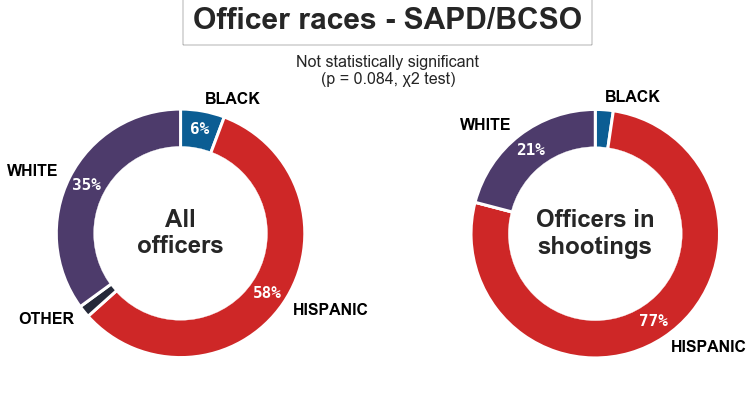

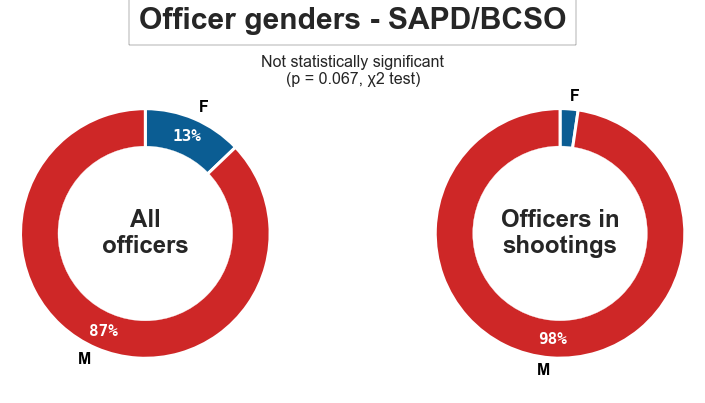

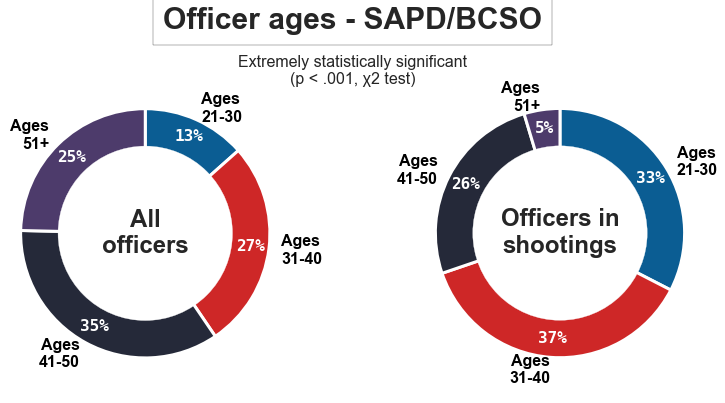

In [12]:
for col in ['race', 'gender', 'age_range']:
    s1 = bexar_officers[col].value_counts().sort_index()
    s1.name = 'All officers'
    s2 = ois_bexar_officers[col].value_counts().sort_index()
    s2.name = 'Officers in shootings'
    df = pd.DataFrame([s1, s2]).T.fillna(0)
    
    title_col = col
    if col == 'age_range':
        df.index = ['Ages\n%s' % i for i in df.index]
        title_col = 'age'

    chi, p = stats.chi2_contingency(df.values)[:2]

    fig, ax = pie_plot(df, donut=True, title='Officer %ss - SAPD/BCSO' % title_col, startangle=90)
    add_significance(fig, p, chi=True)
    plotsaver.saveplot(fig, 'officer_%s' % title_col)

## [2] how many of Texas' officer-involved shootings are in Bexar County?

In [13]:
pop_metric = 'Population estimates, July 1, 2017,  (V2017)'
s = census[census.metric_description == pop_metric]
bexar_pop = float(s['bexar'])
bexar_pop_pct = bexar_pop * 100 / float(s['all_texas'])
bexar_pop_pct

6.9196465478609905

In [14]:
print('* %d total OIS incidents in Texas (killing %d civilians)' % (len(shot_civ), len(shot_civ_full)))
shot_bexar = shot_civ[shot_civ.incident_county == 'BEXAR']
print('* %d incidents were in Bexar county (%.1f%%)' % (len(shot_bexar), len(shot_bexar) * 100 / len(shot_civ)))
print('* Bexar county has %.1f%% of the Texas population' % bexar_pop_pct)
print('* %d incidents involved at least one BCSO/SAPD officer (%.1f%%)' % (sum(incidents), sum(incidents) * 100 / len(shot_civ)))
print('* %d total TX officers were recorde in these incidents' % len(ois_officers))
print('* %d total officers from BCSO/SAPD were recorded (%.1f%%)' % (len(ois_bexar_officers), len(ois_bexar_officers) * 100 / len(ois_officers)))


* 467 total OIS incidents in Texas (killing 486 civilians)
* 45 incidents were in Bexar county (9.6%)
* Bexar county has 6.9% of the Texas population
* 36 incidents involved at least one BCSO/SAPD officer (7.7%)
* 740 total TX officers were recorde in these incidents
* 43 total officers from BCSO/SAPD were recorded (5.8%)


## [3] How many of Texas' custodial deaths are in Bexar County? Jails, prisons, police?

In [15]:
cdr_bexar = cdr[cdr.death_location_county == 'BEXAR']
print('* Total custodial deaths in Bexar county since 2005: %d (%.1f%% of Texas\'s total)' % (
    len(cdr_bexar), len(cdr_bexar) * 100 / len(cdr)))
custodies = set(cdr_bexar['type_of_custody'])
for c in custodies:
    count = sum(cdr_bexar['type_of_custody'] == c)
    print("* %d (%.1f%%) of Bexar's custodial deaths were in %s" % (count, count * 100 / len(cdr_bexar), c.lower()))

* Total custodial deaths in Bexar county since 2005: 274 (3.1% of Texas's total)
* 9 (3.3%) of Bexar's custodial deaths were in prison
* 1 (0.4%) of Bexar's custodial deaths were in private facility
* 177 (64.6%) of Bexar's custodial deaths were in police custody (pre-booking)
* 87 (31.8%) of Bexar's custodial deaths were in jail


## [4] Compare racial demographics of custodial deaths to racial demographics of Bexar County? 

In [16]:
frame = census[census.metric_subcategory == 'Race and Hispanic Origin'][['metric_description', 'bexar']]
frame.set_index('metric_description', drop=True, inplace=True)
frame

,bexar
metric_description,
"American Indian and Alaska Native alone, percent",1.2
"Asian alone, percent",3.1
"Black or African American alone, percent",8.5
"Hispanic or Latino, percent",59.9
"Native Hawaiian and Other Pacific Islander alone, percent",0.2
"Two or More Races, percent",2.3
"White alone, not Hispanic or Latino, percent",28.2
"White alone, percent",84.8


In [17]:
s = frame['bexar'].astype(float)
races = {}
races['OTHER'] = (s['American Indian and Alaska Native alone, percent']
                  + s['Asian alone, percent']
                  + s['Native Hawaiian and Other Pacific Islander alone, percent'])
races['BLACK'] = s['Black or African American alone, percent']
races['WHITE'] = s['White alone, not Hispanic or Latino, percent']
races['HISPANIC'] = s['Hispanic or Latino, percent']
total = sum(races.values())
print('Total percentage inferred:', total)
for k, v in races.items():
    races[k] = int(round(bexar_pop * races[k] / total))
races

Total percentage inferred: 101.1


{'OTHER': 87177, 'BLACK': 164668, 'WHITE': 546310, 'HISPANIC': 1160424}

In [18]:
frame = pd.DataFrame.from_records([races, cdr_bexar['race'].value_counts().to_dict()]).T
frame.columns=['Population', 'CDR']

Saving plot to ../plots/san_antonio_race_cdr_vs_population.png


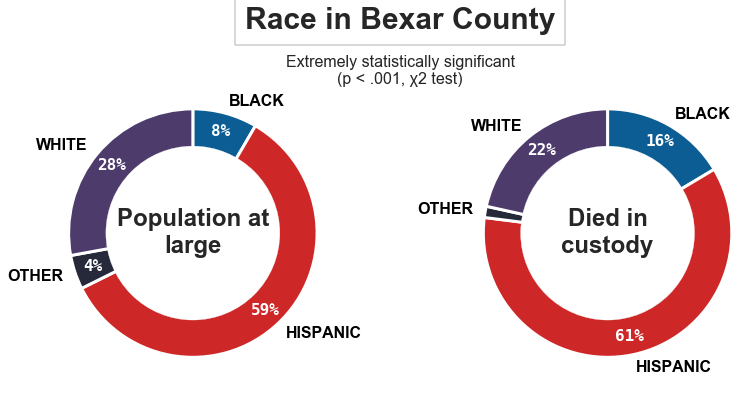

In [19]:

s1 = pd.Series(races).sort_index()
s1.name = 'Population at large'
s2 = cdr_bexar['race'].value_counts().sort_index()
s2.name = 'Died in custody'
df = pd.DataFrame([s1, s2]).T.fillna(0)

chi, p = stats.chi2_contingency(df.values)[:2]

fig, ax = pie_plot(df, donut=True, title='Race in Bexar County', startangle=90)
add_significance(fig, p, chi=True)
plotsaver.saveplot(fig, 'race_cdr_vs_population')